# SCA attack on LEIA captured traces

Welcome to this tutorial exposing how to attack AES traces captured using the LEIA board. These traces have been acquired using LEIA capturing power consumption from a FUNcard running a non secure AES.
A trigger on the smart card has been used to isolate the AES rounds and ease the analysis.

The tutorial first explains how to load the dataset made of 200.000 traces of 2,500,002 points each, then perform an ANOVA (Analysis of variance) for leakage analysis (and points of interest extraction) of the first round `Sbox` output, and finally exploit a QDA (Quadratic Discriminant Analysis) to train a model on a training subset and extract the correct key first byte on a testing subset of the traces.

In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.feature_selection import f_classif
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA


Using TensorFlow backend.


## Dataset loading

We start by loading the dataset and display the dataset keys.

In [2]:
f = h5py.File("/media/rstrullu/5296aec1-6e1b-4f34-a077-4e7a77173e49/LEIA/out_multi_trig_solo.h5", "r")
f.keys()

[u'ciphertexts', u'keys', u'plaintexts', u'traces', u'triggers']

In [3]:
f['traces'].shape

(200000, 2500002)

The dataset has 200.000 traces with 2.500.002 points for each trace.
We plot the first trace of the dataset.

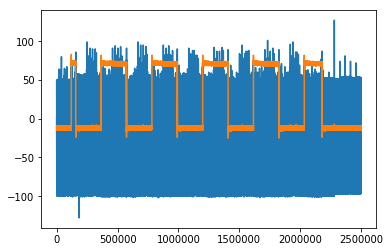

In [4]:
plt.plot(f['traces'][0])
plt.plot(f['triggers'][0])

The toggles in the trigger signal (orange) are synchronized with the beginning of the AES rounds. Therefore we can observe the 10 rounds of the 128-bit key AES. We focus our attention on the first round of the AES, which corresponds to the points in the range ~150.000 until ~370.000 according to the trigger signal.

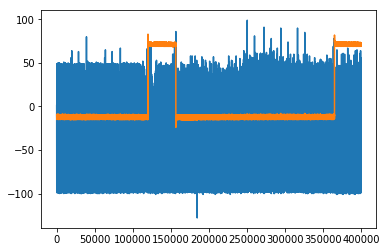

In [5]:
plt.plot(f['traces'][0][:400000])
plt.plot(f['triggers'][0][:400000])

## Leakage analysis

We have identified the first round of the AES. We now perform an ANOVA (Analysis of variance) to understand the different leakages and the correspondence with the sensitive value computed during the AES encryption. More precisely, we use the Fisher F-value (f_classif function of sklearn) to identify the points of interest. The F-value is a common tool in Machine Learning to reduce the number of points. This is similar to the SNR or NICV techniques (https://eprint.iacr.org/2013/717.pdf) used among the Side Channel community.

The next function performs an ANOVA on the traces with the sensitive computed associated data. The traces are splitted in several shards and the ANOVA is performed on each shard. This allows to limit the memory usage.

In [6]:
def compute_anova(f, index, associated_data, parallelized=True, shard_nb=100, tot_pts=None):  
    if(tot_pts==None):
        tot_pts = f['traces'].shape[1]    
    snr_fval = {}

    if parallelized:
        pts = np.int(tot_pts/shard_nb)
        table_snr_fval = []
        for i in tqdm(range(shard_nb)):
            X = f['traces'][index,i*pts:(i+1)*pts]
            entry_snr_fval = {}
            for k in associated_data.keys():
                fval, _ = f_classif(X, associated_data[k])
                entry_snr_fval[k] = fval
            table_snr_fval.append(entry_snr_fval)
        for k in table_snr_fval[0].keys():
            snr_fval[k] = np.concatenate([table_snr_fval[i][k] for i in range(shard_nb)])
    else:
        X = f['traces'][index,:]
        for k in associated_data.keys():
            fval, _ = f_classif(X, associated_data[k])
    return snr_fval

We define the AES `Sbox` that will be used to compute our sensitive values.

In [7]:
Sbox = np.array([
            0x63, 0x7C, 0x77, 0x7B, 0xF2, 0x6B, 0x6F, 0xC5, 0x30, 0x01, 0x67, 0x2B, 0xFE, 0xD7, 0xAB, 0x76,
            0xCA, 0x82, 0xC9, 0x7D, 0xFA, 0x59, 0x47, 0xF0, 0xAD, 0xD4, 0xA2, 0xAF, 0x9C, 0xA4, 0x72, 0xC0,
            0xB7, 0xFD, 0x93, 0x26, 0x36, 0x3F, 0xF7, 0xCC, 0x34, 0xA5, 0xE5, 0xF1, 0x71, 0xD8, 0x31, 0x15,
            0x04, 0xC7, 0x23, 0xC3, 0x18, 0x96, 0x05, 0x9A, 0x07, 0x12, 0x80, 0xE2, 0xEB, 0x27, 0xB2, 0x75,
            0x09, 0x83, 0x2C, 0x1A, 0x1B, 0x6E, 0x5A, 0xA0, 0x52, 0x3B, 0xD6, 0xB3, 0x29, 0xE3, 0x2F, 0x84,
            0x53, 0xD1, 0x00, 0xED, 0x20, 0xFC, 0xB1, 0x5B, 0x6A, 0xCB, 0xBE, 0x39, 0x4A, 0x4C, 0x58, 0xCF,
            0xD0, 0xEF, 0xAA, 0xFB, 0x43, 0x4D, 0x33, 0x85, 0x45, 0xF9, 0x02, 0x7F, 0x50, 0x3C, 0x9F, 0xA8,
            0x51, 0xA3, 0x40, 0x8F, 0x92, 0x9D, 0x38, 0xF5, 0xBC, 0xB6, 0xDA, 0x21, 0x10, 0xFF, 0xF3, 0xD2,
            0xCD, 0x0C, 0x13, 0xEC, 0x5F, 0x97, 0x44, 0x17, 0xC4, 0xA7, 0x7E, 0x3D, 0x64, 0x5D, 0x19, 0x73,
            0x60, 0x81, 0x4F, 0xDC, 0x22, 0x2A, 0x90, 0x88, 0x46, 0xEE, 0xB8, 0x14, 0xDE, 0x5E, 0x0B, 0xDB,
            0xE0, 0x32, 0x3A, 0x0A, 0x49, 0x06, 0x24, 0x5C, 0xC2, 0xD3, 0xAC, 0x62, 0x91, 0x95, 0xE4, 0x79,
            0xE7, 0xC8, 0x37, 0x6D, 0x8D, 0xD5, 0x4E, 0xA9, 0x6C, 0x56, 0xF4, 0xEA, 0x65, 0x7A, 0xAE, 0x08,
            0xBA, 0x78, 0x25, 0x2E, 0x1C, 0xA6, 0xB4, 0xC6, 0xE8, 0xDD, 0x74, 0x1F, 0x4B, 0xBD, 0x8B, 0x8A,
            0x70, 0x3E, 0xB5, 0x66, 0x48, 0x03, 0xF6, 0x0E, 0x61, 0x35, 0x57, 0xB9, 0x86, 0xC1, 0x1D, 0x9E,
            0xE1, 0xF8, 0x98, 0x11, 0x69, 0xD9, 0x8E, 0x94, 0x9B, 0x1E, 0x87, 0xE9, 0xCE, 0x55, 0x28, 0xDF,
            0x8C, 0xA1, 0x89, 0x0D, 0xBF, 0xE6, 0x42, 0x68, 0x41, 0x99, 0x2D, 0x0F, 0xB0, 0x54, 0xBB, 0x16
            ])

The next function computes the sensitive values that we want to identify in the leakages (these are the sensitive associated data that will be provided to the ANOVA analysis). The sensitive values are the key value, the plaintext value and the `Sbox` output value for each byte `i`. The function returns a dictionary of arrays, each array contains the list of sensitive values of all the traces.

In [8]:
def get_data(f, index):
    pt = []
    for i in range(16):
        pt.append(f['plaintexts'][index, i])
    pt = np.array(pt)
    key = []
    for i in range(16):
        key.append(f['keys'][index, i])
    key = np.array(key)
    sbox = []
    for i in range(16):
        sbox.append(Sbox[pt[i]]^key[i])
    sbox = np.array(sbox)

    label_l = ["pt[{}]".format(i) for i in range(16)]
    label_l += ["key[{}]".format(i) for i in range(16)]
    label_l += ["sbox[{}]".format(i) for i in range(16)]

    associated_data = {}
    for k in label_l:
        associated_data[k] = eval(k)
    
    return associated_data

To perform our ANOVA, we select the 10.000 first traces. We compute the corresponding sensitive values and we apply our ANOVA function.

In [9]:
data_len = 10000
index = range(data_len)
associated_data = get_data(f, index)
snr_fval = compute_anova(f, index, associated_data, parallelized=True, shard_nb=10, tot_pts=400000)

  0%|          | 0/10 [00:00<?, ?it/s]/home/rstrullu/venv/local/lib/python2.7/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):
100%|██████████| 10/10 [16:03<00:00, 99.89s/it]


We display the F-value of the 16 plaintext bytes. The corresponding leakages spots are identified arround the 150.000th point.

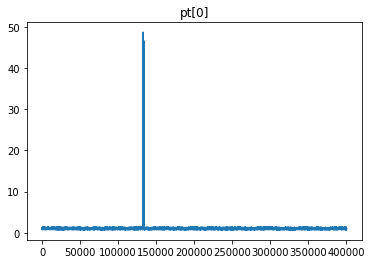

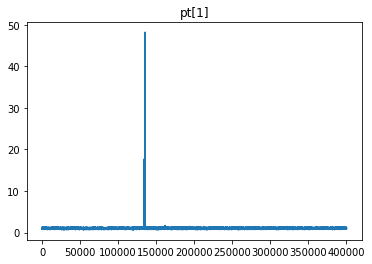

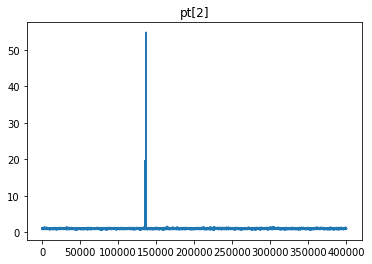

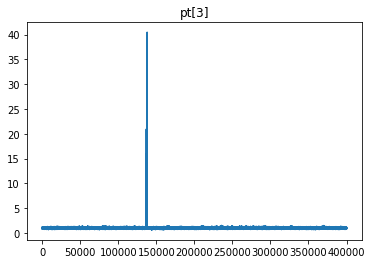

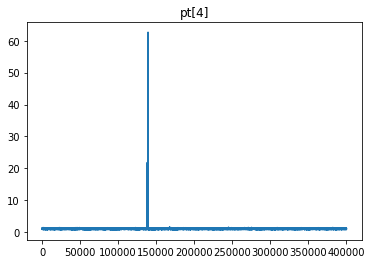

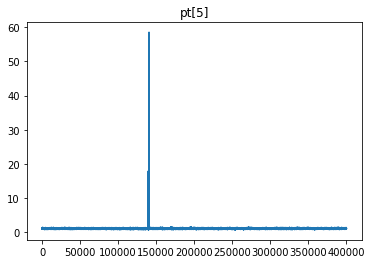

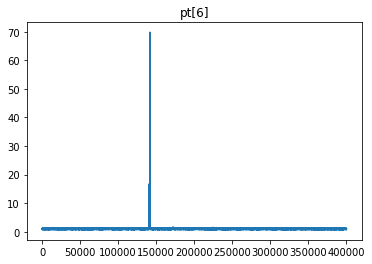

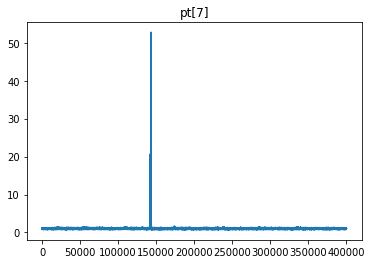

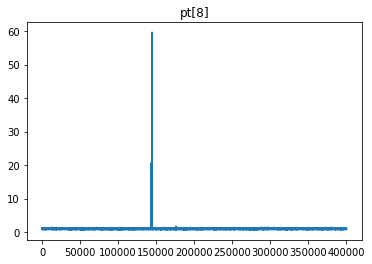

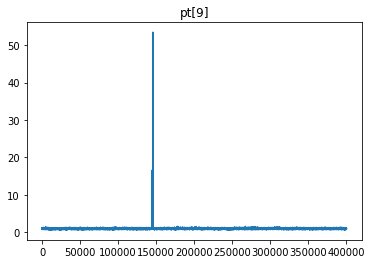

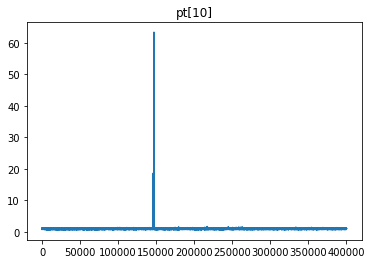

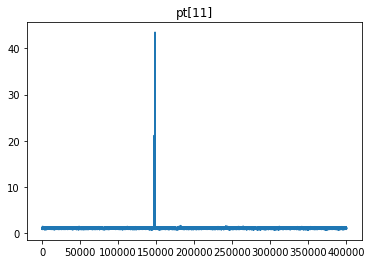

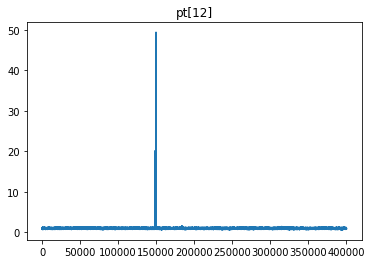

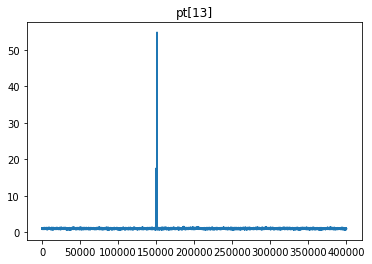

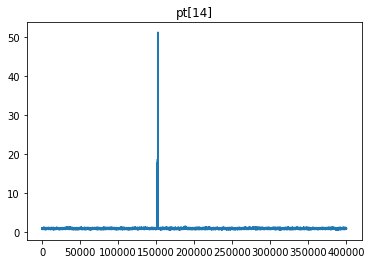

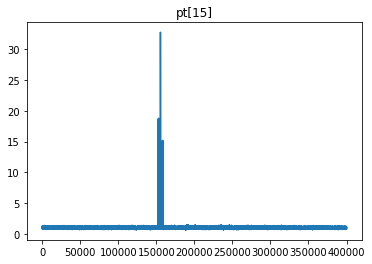

In [10]:
l = ["pt[{}]".format(i) for i in range(16)]
for k in l:
    plt.title(k)
    plt.plot(snr_fval[k])
    plt.show()

We display the F-value of the 16 key bytes to get the corresponding leakages spots.

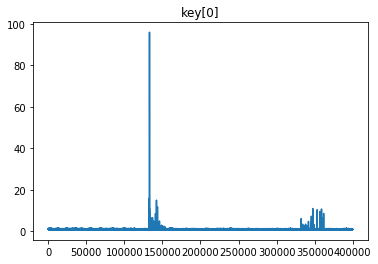

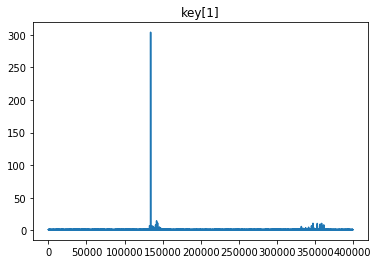

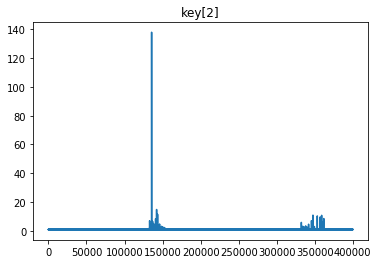

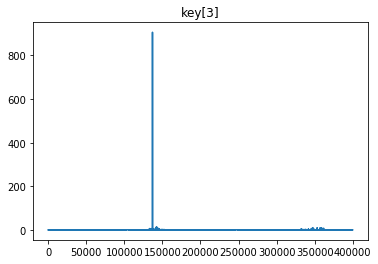

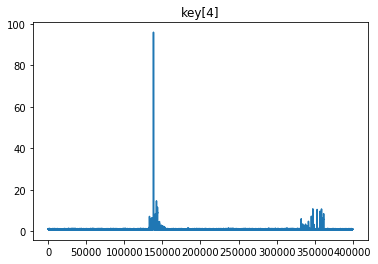

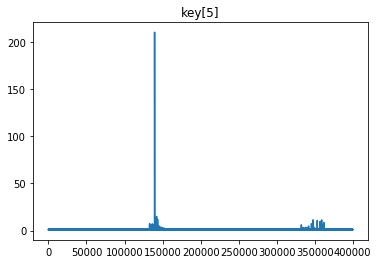

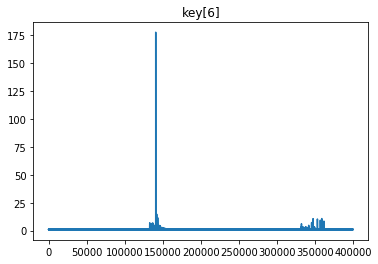

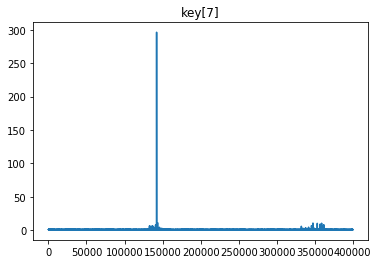

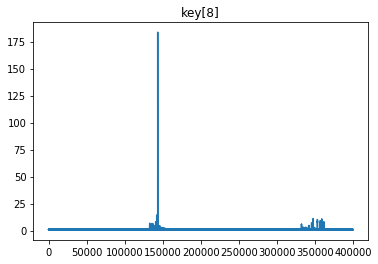

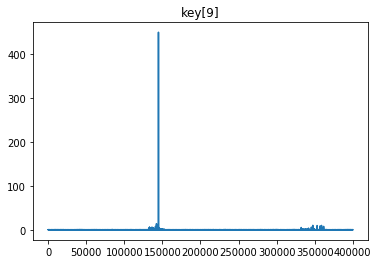

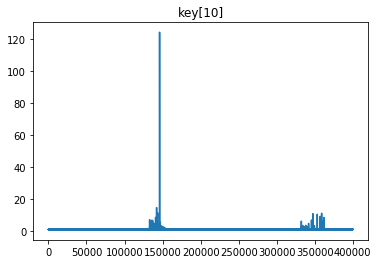

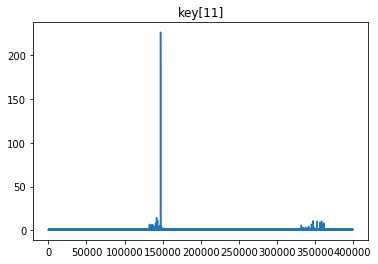

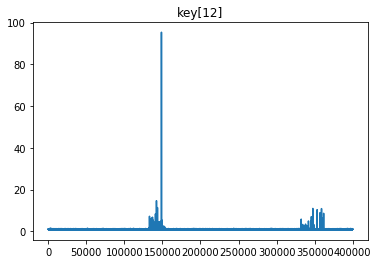

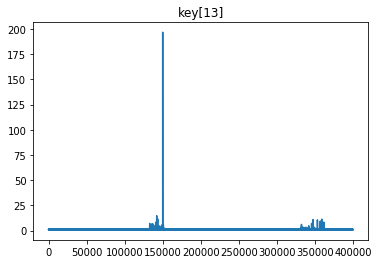

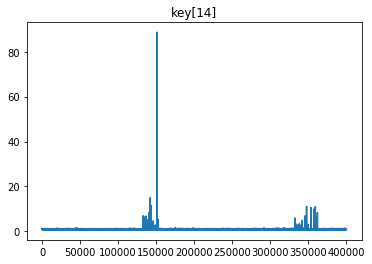

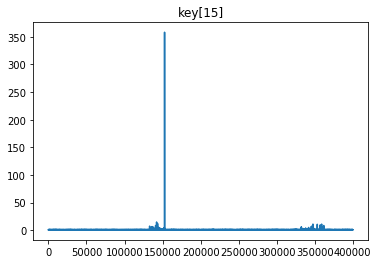

In [11]:
l = ["key[{}]".format(i) for i in range(16)]
for k in l:
    plt.title(k)
    plt.plot(snr_fval[k])
    plt.show()

Finally, we display the F-value of the 16 Sbox output bytes.

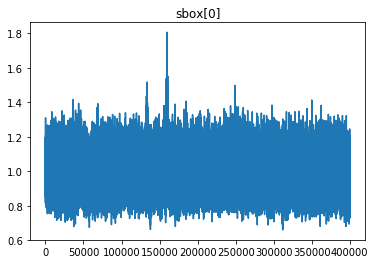

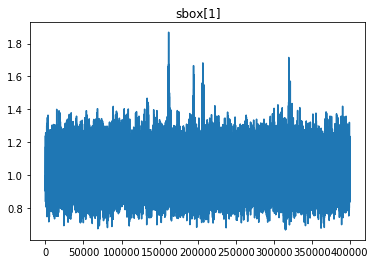

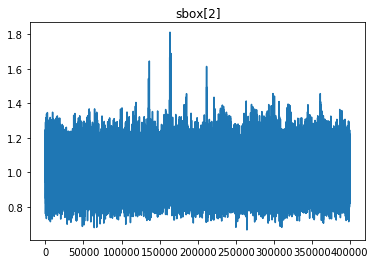

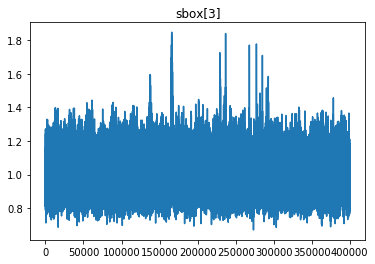

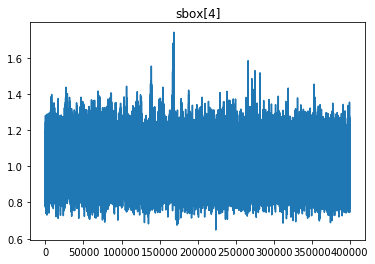

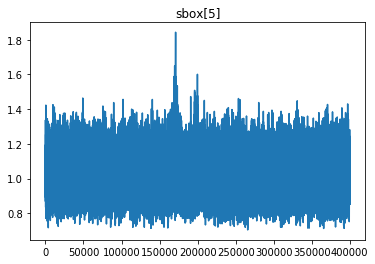

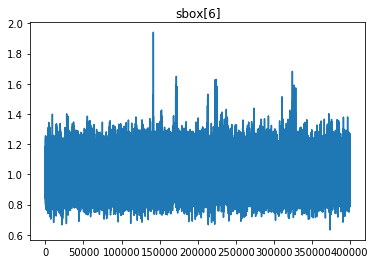

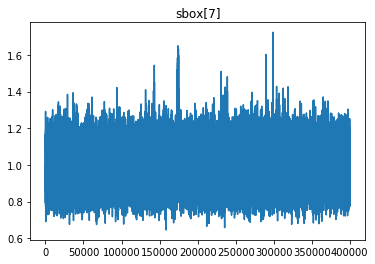

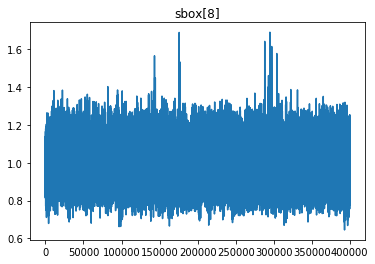

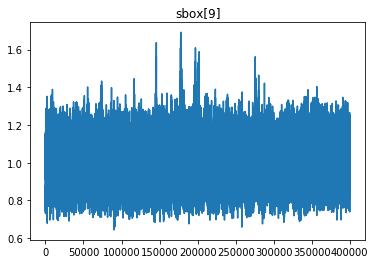

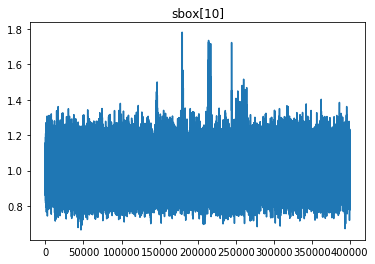

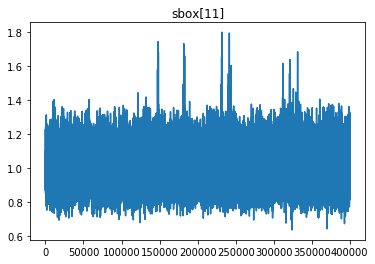

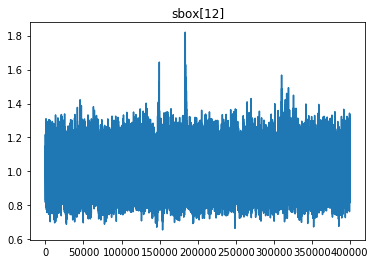

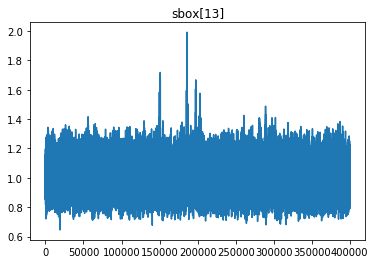

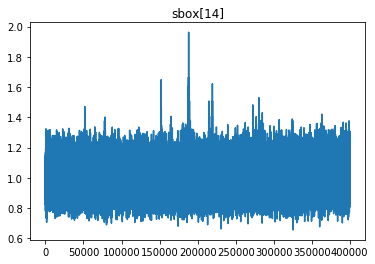

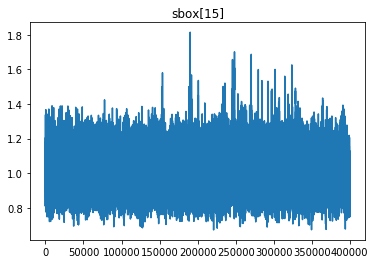

In [12]:
l = ["sbox[{}]".format(i) for i in range(16)]
for k in l:
    plt.title(k)
    plt.plot(snr_fval[k])
    plt.show()

## Attack on the first byte of the key

We choose to attack the first byte of the key. The other bytes can be obtained in a similar way. We first select the points of the trace for which the F-value is above a given threshold. The power consumption for these points corresponds to the leakage of the Sbox output.

In [13]:
ind = np.where(snr_fval['sbox[0]']>1.6)[0]
ind

array([159542, 159546, 159597, 159598, 159601, 159602, 159603, 159604,
       159606, 159607, 159608, 159611, 159612, 159613, 159614, 159615,
       159616, 159617, 159618, 159620, 159621, 159625, 159899])

We display the first key byte value for the 100 first traces. The key is always the same every 10 traces, and is random for the other traces.

In [14]:
f['keys'][:100,0]

array([ 43, 132, 149,  32,   4, 220, 242, 110, 149, 161,  43, 110,  12,
       138,  99,  70,  30,  87, 155, 170,  43,   3, 203,  50, 103, 159,
        62, 102, 238,  58,  43, 193,  59, 182, 153, 203, 191, 207, 246,
        33,  43,  47, 189, 142,  72,   4, 106, 131, 151, 114,  43, 255,
        27,  70,  33, 243, 220,  18, 196, 248,  43, 237, 207,  15, 131,
       149,  27, 251, 153, 152,  43,  39, 187,  49,  45,  36, 211,   4,
       236, 241,  43,  22, 142, 209,  23,  21, 119, 216, 127, 246,  43,
        52,  48, 209, 113, 157, 120, 181, 209, 199], dtype=uint8)

We select the 100.000 first traces and we reduce the points to the `Sbox` leakage.

In [15]:
datalen = 100000
X_qda = f['traces'][:datalen, ind]

We target the first sbox output.

In [17]:
target_byte = 0
data = np.array([f['plaintexts'][:datalen,target_byte], f['keys'][:datalen,target_byte]]).T

def sbox_f(pt, k):
    return Sbox[pt^k]

We split the dataset into a train dataset and a test dataset. The train dataset has random keys, and the test dataset has a fixed key,

In [30]:
ind_train = [i%10 !=0 for i in range(datalen)]
ind_test = [i%10 == 0 for i in range(datalen)]

X_train, X_test, data_train, data_test = X_qda[ind_train], X_qda[ind_test], data[ind_train], data[ind_test]
y_train = np.array([sbox_f(pt, k) for (pt,k) in data_train])
y_test = np.array([sbox_f(pt, k) for (pt,k) in data_test])

We train a Quadratic Disciminant Analysis model. This is equivalent to a Side-Channel Template Attack.

In [20]:
clf = QDA()
clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
               store_covariances=False, tol=0.0001)

The model has a high accuracy on our test dataset, it is able to recover the right key 17% of the time on a single trace.

In [33]:
clf.score(X_test, y_test)

0.1779

We evaluate our model on several traces. We compute the rank of the right key by using a MLE (Maximum Likelihood Estimation) for the different key hypotheses. This an usual evaluation criteria for Side-Channel Attacks.

In [32]:
def pos(lh,k):
    t = zip(range(len(lh)), lh)
    st = sorted(t, key=lambda u: u[1], reverse=True)
    x, _ = zip(*st)
    x = np.array(x)
    ind = np.where(x == k)[0][0]
    return ind

def rank(proba, pt, key):
    epsilon = 10**-10       
    lh = np.zeros((len(proba),256))
    lh_l = 0              
    for i in range(len(proba)):
        p = proba[i]
        p += epsilon
        sensitive_vector = [Sbox[pt[i]^k] for k in range(256)]
        lh[i] = lh_l + (np.log(p[sensitive_vector])) 
        lh_l = lh[i]
    rk = [pos(lh[i],key) for i in range(len(lh))]
    return rk

In [34]:
proba = clf.predict_proba(X_test)

We display the rank of the correct key versus the number of traces. The correct key is found in two traces.

In [35]:
rank(proba, data_test[:,0], data_test[:,1][0])

[35,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,

In [ ]:
def avg_rk(clf, X_test, data_test, nest):
    l = len(X_test)
    proba = clf.predict_proba(X_test)
    rks = []
    for i in tqdm(range(nest)):
        perm = np.random.choice(l, size=l)
        rks.append(rank(proba, pt[perm])
    mean = np.mean(rks, axis=0)
    std = np.std(rks, axis=0)
    return mean, std